reference: https://colab.research.google.com/drive/11_Aw-ZkjjUQ8lZREscFYTyig2UaANS4s?usp=sharing

## 事前準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# work spaceにコピー
%%bash
cp -r /content/drive/MyDrive/tool/git-clone/yolov5 /content/

mkdir /content/data
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/train_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/test_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/add_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/rot.zip /content/data/

cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_train.csv /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_test.csv /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_add.csv /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/rot.csv /content/data/

unzip /content/data/train_resize_512.zip -d "/content/data/"
unzip /content/data/test_resize_512.zip -d "/content/data/"
unzip /content/data/add_resize_512.zip -d "/content/data/"
unzip /content/data/rot.zip -d "/content/data/"

Archive:  /content/data/train_resize_512.zip
   creating: /content/data/train_resize_512/
  inflating: /content/data/train_resize_512/cf7dee34.jpg  
  inflating: /content/data/train_resize_512/4ae939e7.jpg  
  inflating: /content/data/train_resize_512/92bb5890.jpg  
  inflating: /content/data/train_resize_512/ca35d666.jpg  
  inflating: /content/data/train_resize_512/b8d07ead.jpg  
  inflating: /content/data/train_resize_512/399bd91a.jpg  
  inflating: /content/data/train_resize_512/c260c3bb.jpg  
  inflating: /content/data/train_resize_512/7d98f35f.jpg  
  inflating: /content/data/train_resize_512/747edaa6.jpg  
  inflating: /content/data/train_resize_512/204d81c4.jpg  
  inflating: /content/data/train_resize_512/feb03e37.jpg  
  inflating: /content/data/train_resize_512/e993b985.jpg  
  inflating: /content/data/train_resize_512/e1deda4c.jpg  
  inflating: /content/data/train_resize_512/8f496fee.jpg  
  inflating: /content/data/train_resize_512/7addaafe.jpg  
  inflating: /content/dat

In [3]:
# equirements.txtに記載のライブラリのインストールする
%cd /content/yolov5/
!pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 13.8 MB/s 


In [4]:
# ライブラリインポート
import ast, torch, shutil, yaml, os, cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from glob import glob
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm
from IPython.display import Image, clear_output 

In [5]:
# path
DATA_ROOT = "/content/data/"

TRAIN_PATH = "/content/data/train_resize_512/"
TEST_PATH = "/content/data/test_resize_512/"
ADD_PATH = "/content/data/add_resize_512/"
ROT_PATH = "/content/data/rot/"

In [6]:
# データフレーム
# path列は画像リサイズ時に使用したものであり更新が必要
df_train = pd.read_csv(DATA_ROOT + "df_train.csv")
df_test = pd.read_csv(DATA_ROOT + "df_test.csv")
df_add = pd.read_csv(DATA_ROOT + "df_add.csv")
df_rot = pd.read_csv(DATA_ROOT + "rot.csv")

print(len(df_train), len(df_add), len(df_rot))


# Xmin_Ymin_Xmax_Ymaxはread_csvするとstr型なので、リストで扱えるように変換
df_train["resized_box"] = [ast.literal_eval(d) for d in df_train["resized_box"]]
df_add["resized_box"] = [ast.literal_eval(d) for d in df_add["resized_box"]]
df_rot["resized_box"] = [ast.literal_eval(d) for d in df_rot["resized_box"]]


# trainのpath更新
df_train = df_train.drop('path', axis=1)

paths = glob(TRAIN_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_train = pd.merge(df_train, df_path, on='filename')


# testのpath更新
df_test = df_test.drop('path', axis=1)

paths = glob(TEST_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_test = pd.merge(df_test, df_path, on='filename')


# addのpath更新
df_add = df_add.drop('path', axis=1)
paths = glob(ADD_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_add = pd.merge(df_add, df_path, on='filename')


# rotのpath更新
df_rot = df_rot.drop('path', axis=1)
paths = glob(ROT_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_rot = pd.merge(df_rot, df_path, on='filename')


# trainとaddを結合
df_train = df_train[["filename", "class", "resized_box", "path"]]
df_add = df_add[["filename", "class", "resized_box", "path"]]

df_train = pd.concat([df_train, df_add]).reset_index().drop('index', axis=1)


# trainとrot結合
df_train = pd.concat([df_train, df_rot]).reset_index().drop('index', axis=1)

df_train

2371 1648 237


,filename,class,resized_box,path
0,2f71963a.jpg,HDMI,"[156, 192, 264, 280]",/content/data/train_resize_512/2f71963a.jpg
1,8cdf4bda.jpg,USB_Mini,"[244, 194, 292, 254]",/content/data/train_resize_512/8cdf4bda.jpg
2,7ac35f30.jpg,Dock,"[113, 212, 337, 287]",/content/data/train_resize_512/7ac35f30.jpg
3,f6641c06.jpg,Lightning,"[210, 223, 303, 269]",/content/data/train_resize_512/f6641c06.jpg
4,4fdc8d7d.jpg,USB_Micro_B,"[266, 133, 378, 215]",/content/data/train_resize_512/4fdc8d7d.jpg
...,...,...,...,...
4251,8698df0e_rot180.jpg,USB_Micro_B_W,"[133, 163, 235, 239]",/content/data/rot/8698df0e_rot180.jpg
4252,091ebb75_rot180.jpg,USB_Micro_B_W,"[192, 226, 263, 252]",/content/data/rot/091ebb75_rot180.jpg
4253,4091f2c5_rot180.jpg,USB_Micro_B_W,"[220, 282, 308, 332]",/content/data/rot/4091f2c5_rot180.jpg
4254,891b18b7_rot180.jpg,USB_Micro_B_W,"[184, 202, 278, 238]",/content/data/rot/891b18b7_rot180.jpg


'Lightning_T'

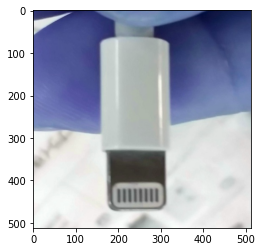

In [7]:
import matplotlib.pyplot as plt

i = np.random.randint(len(df_rot))
path = df_rot["path"].iloc[i]
img = cv2.imread(path)

plt.imshow(img)
df_rot["class"].iloc[i]

In [ ]:
"""## bounding boxを少し拡大
new_bb = []
rate = 5 * 0.01    # 5%

for i in range(len(df_train)):
    xmin, ymin, xmax, ymax = df_train["resized_box"].iloc[i]
    xmin = int(xmin - rate*xmin)
    ymin = int(ymin - rate*ymin)
    xmax = int(xmax + rate*xmax)
    ymax = int(ymax + rate*ymax)

    new_bb.append([xmin, ymin, xmax, ymax])

df_tmp = df_train.copy()
df_tmp["bb"] = new_bb

# 確認
i = np.random.randint(len(df_tmp))

path = df_tmp["path"][i]
row_img = cv2.imread(path)
row_img = cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB)
cv2.rectangle(row_img, (df_tmp["resized_box"][i][0], df_tmp["resized_box"][i][1]), (df_tmp["resized_box"][i][2], df_tmp["resized_box"][i][3]), 255, 5)


new_img = cv2.imread(path)
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
cv2.rectangle(new_img, (df_tmp["bb"][i][0], df_tmp["bb"][i][1]), (df_tmp["bb"][i][2], df_tmp["bb"][i][3]), 255, 5)
        
        
plt.subplot(121)
plt.imshow(row_img)
    
plt.subplot(122)
plt.imshow(new_img)

plt.show()"""
pass

In [8]:
# trainデータをtrainとvalへ分割
df = df_train.copy()
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=5)

print(len(df_train))
print(len(df_val))

3404
852


In [9]:
# GPUまたはCPUのどちらを使用するか設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## 前処理 for YOLO

### labelとアノテーションデータのtxtファイル作成

In [10]:
!mkdir /content/datasets
!mkdir /content/datasets/labels

LABEL_PATH = "/content/datasets/labels/"

In [11]:
# コンペで配布された物体検出アノテーションをYOLOで学習できる形式へ変換
# Xmin Ymin Xmax Ymaxの形式からx_center y_center width heightの形式へ変更しさらに0-1のスケールへと変換

def convert2yolo(size, box):
    dw = 1./size[1]
    dh = 1./size[0]

    x_center = (float(box[0]) + float(box[2])) / 2.0
    y_center = (float(box[1]) + float(box[3])) / 2.0

    w = float(box[2]) - float(box[0])
    h = float(box[3]) - float(box[1])

    x_center = x_center * dw
    w = w * dw
    
    y_center = y_center * dh
    h = h*dh
    
    return x_center, y_center, w, h

In [12]:
dict_label = {
    0: 'DisplayPort',
    1: 'Dock',
    2: 'HDMI',
    3: 'Lightning',
    4: 'Lightning_T',
    5: 'Mini_DisplayPort',
    6: 'RJ_45',
    7: 'USB_Micro_B',
    8: 'USB_Micro_B_3.1',
    9: 'USB_Micro_B_W',
    10: 'USB_Mini',
    11: 'USB_Type_A',
    12: 'USB_Type_B',
    13: 'USB_Type_C',
    14: 'VGA'
}

dict_id2class = { k:v for v,k in dict_label.items() }

In [13]:
# train-labelを格納
os.makedirs(LABEL_PATH + "train", exist_ok = True)  # ディレクトリ作成
label_root = LABEL_PATH + "train/"

for (id_, label, box) in zip(df_train["filename"].values, df_train["class"].values, df_train["resized_box"].values):
    id_txt = id_[:-4] + ".txt"              # ファイル名
    txtfile = label_root + id_txt           # パス

    x_center, y_center, w, h = convert2yolo(size=[512, 512], box=box)    # アノテーションデータ変換

    body = str(dict_id2class[label]) + ' ' + str(x_center) + ' ' +str(y_center) + ' ' + str(w) + ' ' + str(h) + ' '
    #body = str(0) + ' ' + str(x_center) + ' ' +str(y_center) + ' ' + str(w) + ' ' + str(h) + ' '

    with open(txtfile, mode="w") as f:
        f.write(body)
        f.write('\n')

In [14]:
# txtに書き込めたかチェック
with open(LABEL_PATH + "train/00037f39.txt", mode="r") as f:
    data = f.read()
data

'3 0.5 0.5 0.19921875 0.1484375 \n'

In [15]:
# val-labelを格納
os.makedirs(LABEL_PATH + "val", exist_ok = True)    # ディレクトリ作成
label_root = LABEL_PATH + "val/"            # パス

for (id_, label, box) in zip(df_val["filename"].values, df_val["class"].values, df_val["resized_box"].values):
    id_txt = id_[:-4] + ".txt"          # ファイル名
    txtfile = label_root + id_txt       # パス

    x_center, y_center, w, h = convert2yolo(size=[512, 512], box=box)    # アノテーションデータ変換

    body = str(dict_id2class[label]) + ' ' + str(x_center) + ' ' +str(y_center) + ' ' + str(w) + ' ' + str(h) + ' '
    #body = str(0) + ' ' + str(x_center) + ' ' +str(y_center) + ' ' + str(w) + ' ' + str(h) + ' '

    with open(txtfile, mode="w") as f:
        f.write(body)

In [16]:
# txtに書き込めたかチェック
with open(LABEL_PATH + "val/0f0213af_rot180.txt", mode="r") as f:
    data = f.read()
data

'9 0.38671875 0.359375 0.28125 0.2109375 '

### 画像データのコピー

In [17]:
!mkdir /content/datasets/images
IMG_PATH = "/content/datasets/images/"

In [18]:
# train
os.makedirs(IMG_PATH + "train", exist_ok=True)
image_root = "/content/datasets/images/train/"
for path in df_train["path"].values:
    shutil.copy(path, image_root)

# validation
os.makedirs(IMG_PATH + "val", exist_ok=True)
image_root = "/content/datasets/images/val/"
for path in df_val["path"].values:
    shutil.copy(path, image_root)

### 画像パスの一覧txtを作成

In [19]:
with open('/content/train.txt', 'w') as f:
    for path in glob("/content/datasets/images/train/*"):
        f.write(path+'\n')

with open('/content/val.txt', 'w') as f:
    for path in glob("/content/datasets/images/val/*"):
        f.write(path+'\n')

In [20]:
# train.txtデータの書き込みチェック
with open('/content/train.txt', 'r') as f:
    data = f.read()
data

'/content/datasets/images/train/d740238f.jpg\n/content/datasets/images/train/28955b1f.jpg\n/content/datasets/images/train/aaa63531.jpg\n/content/datasets/images/train/051c2e38.jpg\n/content/datasets/images/train/620e9c1f.jpg\n/content/datasets/images/train/cc1acd99.jpg\n/content/datasets/images/train/8f96a045.jpg\n/content/datasets/images/train/f87ff9f5.jpg\n/content/datasets/images/train/ab86fe44.jpg\n/content/datasets/images/train/f343a80a.jpg\n/content/datasets/images/train/9b20894f.jpg\n/content/datasets/images/train/23793f85.jpg\n/content/datasets/images/train/4da12d01.jpg\n/content/datasets/images/train/ca5bdc32.jpg\n/content/datasets/images/train/fc007017.jpg\n/content/datasets/images/train/0810d383.jpg\n/content/datasets/images/train/9607bf9d.jpg\n/content/datasets/images/train/a818957b_rot180.jpg\n/content/datasets/images/train/e5ce886c_rot180.jpg\n/content/datasets/images/train/72abacb0.jpg\n/content/datasets/images/train/e0a612f2.jpg\n/content/datasets/images/train/731d65cd_

In [21]:
# val.txtデータの書き込みチェック
with open('/content/val.txt', 'r') as f:
    data = f.read()
data

'/content/datasets/images/val/3b731d76.jpg\n/content/datasets/images/val/a818957b.jpg\n/content/datasets/images/val/3a892eea.jpg\n/content/datasets/images/val/3fc9188c.jpg\n/content/datasets/images/val/7df49978.jpg\n/content/datasets/images/val/52f11620.jpg\n/content/datasets/images/val/67bf8bb9.jpg\n/content/datasets/images/val/af03a51e.jpg\n/content/datasets/images/val/68a7ac41.jpg\n/content/datasets/images/val/749fc650.jpg\n/content/datasets/images/val/055f7894.jpg\n/content/datasets/images/val/408af69c.jpg\n/content/datasets/images/val/6b5f40c0.jpg\n/content/datasets/images/val/40b39ea6.jpg\n/content/datasets/images/val/74e4aef2.jpg\n/content/datasets/images/val/036104e9.jpg\n/content/datasets/images/val/926a7fc3.jpg\n/content/datasets/images/val/8f8472a2.jpg\n/content/datasets/images/val/de744131.jpg\n/content/datasets/images/val/587a4905.jpg\n/content/datasets/images/val/833d6983.jpg\n/content/datasets/images/val/cb2444ad.jpg\n/content/datasets/images/val/7a5df5ff.jpg\n/content/d

### yamlの作成

In [22]:
classes = [
    'DisplayPort',
    'Dock',
    'HDMI',
    'Lightning',
    'Lightning_T',
    'Mini_DisplayPort',
    'RJ_45',
    'USB_Micro_B',
    'USB_Micro_B_3.1',
    'USB_Micro_B_W',
    'USB_Mini',
    'USB_Type_A',
    'USB_Type_B',
    'USB_Type_C',
    'VGA' 
    ]

classes_id = np.arange(0, 15, 1).tolist()

In [23]:
data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 15,
    names = classes
)

data

{'names': ['DisplayPort',
  'Dock',
  'HDMI',
  'Lightning',
  'Lightning_T',
  'Mini_DisplayPort',
  'RJ_45',
  'USB_Micro_B',
  'USB_Micro_B_3.1',
  'USB_Micro_B_W',
  'USB_Mini',
  'USB_Type_A',
  'USB_Type_B',
  'USB_Type_C',
  'VGA'],
 'nc': 15,
 'train': '/content/train.txt',
 'val': '/content/val.txt'}

In [24]:
with open('/content/sanwa.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

# yamlファイル確認
f = open('/content/sanwa.yaml', 'r')
print('yaml:')
print(f.read())

yaml:
names:
- DisplayPort
- Dock
- HDMI
- Lightning
- Lightning_T
- Mini_DisplayPort
- RJ_45
- USB_Micro_B
- USB_Micro_B_3.1
- USB_Micro_B_W
- USB_Mini
- USB_Type_A
- USB_Type_B
- USB_Type_C
- VGA
nc: 15
train: /content/train.txt
val: /content/val.txt



## YOLO学習

In [25]:
# treeコマンドをcolab上で使えるようにインストール
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (713 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


###動作確認

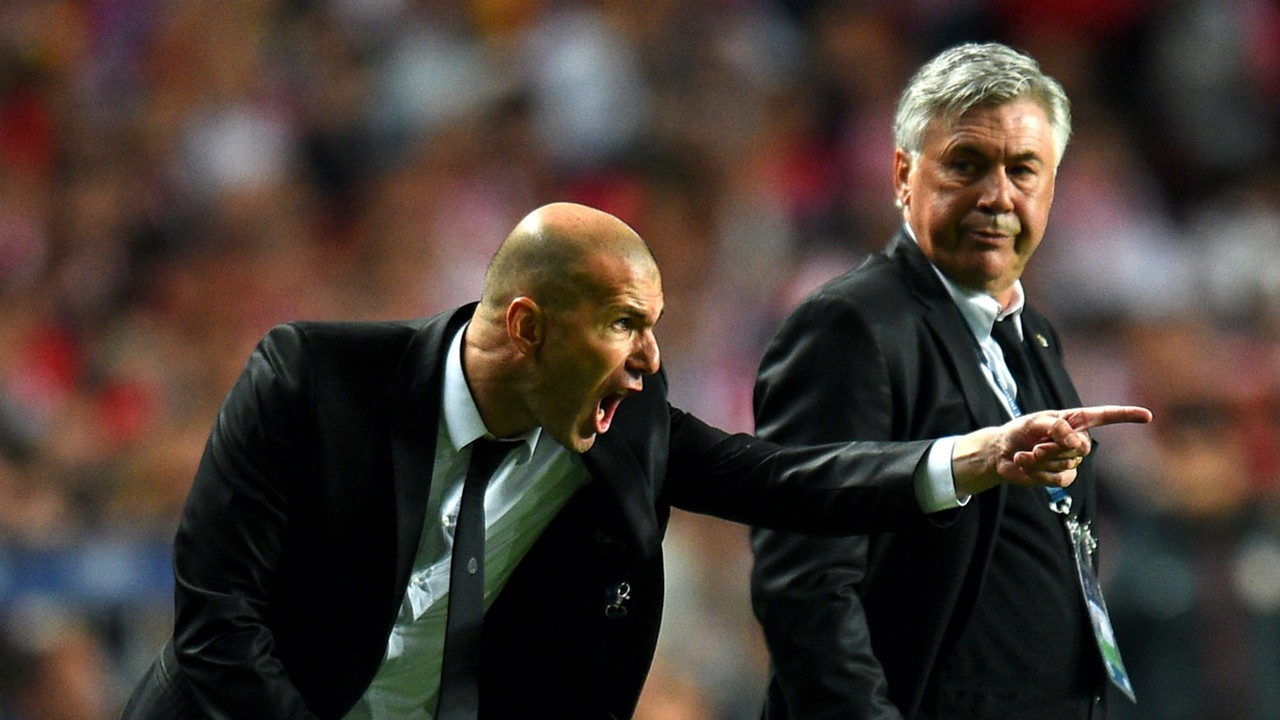

In [ ]:
# 推論実行前の画像
Image(filename='/content/yolov5/data/images/zidane.jpg', width=600)

detect: weights=['yolov5s.pt'], source=data/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-472-gc1bed60 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

100% 14.0M/14.0M [00:00<00:00, 16.4MB/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.009s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, Done. (0.012s)
Speed: 0.4ms pre-process, 10.7ms inference, 14.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


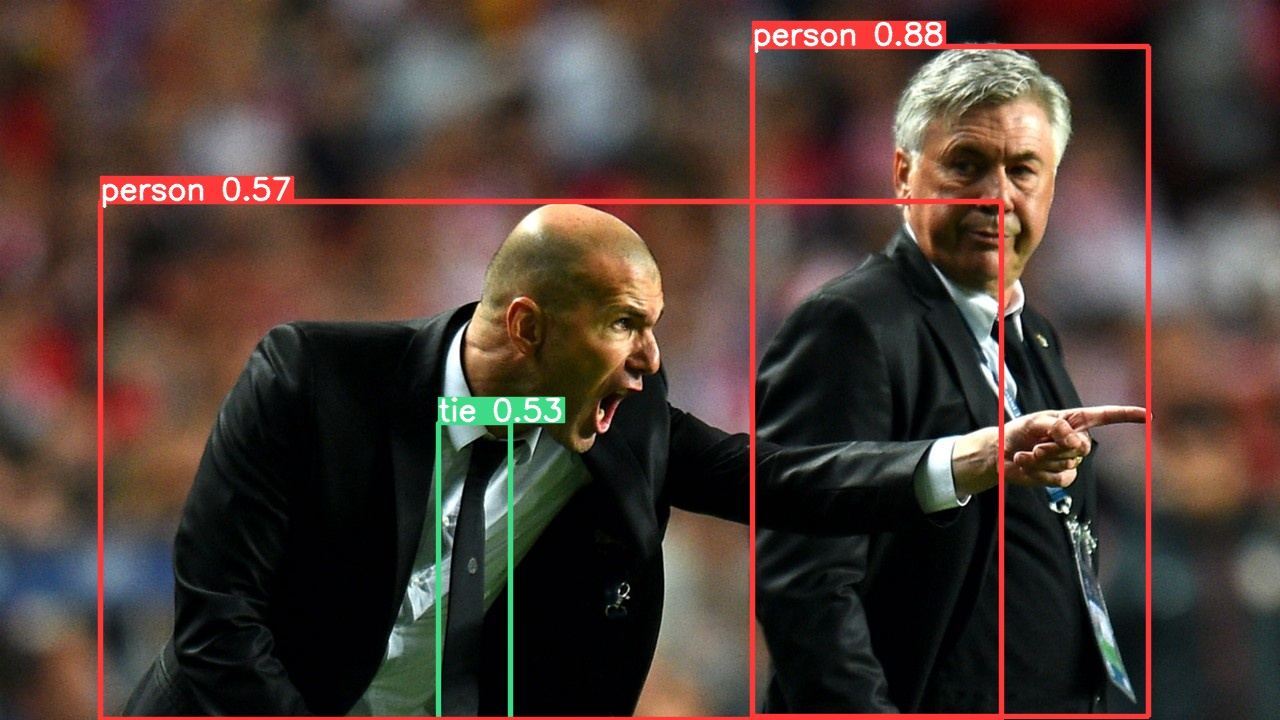

In [ ]:
# 推論の実行
# 推論時にはオプションで以下を指定します。
# 学習済み重みデータ、imgのサイズ、ボックスを表示させるconfidenceのしきい値、推論対象のデータ
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

### 実践

In [50]:
# 学習パラメータの設定
dim = 512
batch_size = 8
epochs = 30

yolo_ver = "yolov5s.yaml"
#weights = "yolov5s.pt"
weights = "/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output/yolov5s_epoch20_2021-11-04-08-10/train_log/weights/best.pt"

In [51]:
!pwd

/content/yolov5


In [52]:
# コンペデータに対して学習を実行
#!python train.py --img $dim --batch $batch_size --epochs $epochs --data /content/sanwa.yaml --weights $weights --cfg $yolo_ver --cache --patience 5
!python train.py --img $dim --batch $batch_size --epochs $epochs --data /content/sanwa.yaml --weights $weights --cfg $yolo_ver --patience 5 --cache --exist-ok

train: weights=/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output/yolov5s_epoch20_2021-11-04-08-10/train_log/weights/best.pt, cfg=yolov5s.yaml, data=/content/sanwa.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, entity=None, project=runs/train, name=exp, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=5
github: ⚠️ YOLOv5 is out of date by 93 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v5.0-472-gc1bed60 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3

### 学習結果の保存

In [53]:
import datetime
from distutils.dir_util import copy_tree

yolo_ver = yolo_ver[:-5]
OUTPUT = "/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output/"

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")

src = "/content/yolov5/runs/train/exp/"

dest = f"{OUTPUT}/{yolo_ver}_epoch{epochs}_{current_time}/train_log"

if not os.path.exists(dest):
    os.makedirs(dest)

copy_tree(src, dest)

['/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/events.out.tfevents.1636013526.f9e2775c1f0b.1007.0',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/events.out.tfevents.1636012014.f9e2775c1f0b.904.0',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/results.png',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/labels_correlogram.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/opt.yaml',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/train_log/val_batch1_labels.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2

## 推論

In [54]:
!python detect.py --source "../data/test_resize_512" --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 512 --conf 0.001 --save-txt --save-conf

# マイドライブから重みデータの読み込み
#!python detect.py --source "../data/test_resize_512" --weights '/content/drive/MyDrive/project/Nishika_cable/YOLO_output/yolov5x_epoch20_2021-10-04-09-48/train_log/weights/best.pt' --img 512 --conf 0.001 --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=../data/test_resize_512, imgsz=[512, 512], conf_thres=0.001, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-472-gc1bed60 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 224 layers, 7091668 parameters, 0 gradients, 16.4 GFLOPs
image 1/2200 /content/data/test_resize_512/0055471d.jpg: 512x512 5 USB_Micro_Bs, 3 USB_Type_Cs, Done. (0.018s)
image 2/2200 /content/data/test_resize_512/007bb9f0.jpg: 512x512 10 Docks, 6 Lightnings, 10 Lightning_Ts, 1 USB_Micro_B, 1 USB_Type_A, 8 USB_Type_Cs, Done. (0.019s)
image 3/2200 /content/data/test_resize_512/00a34678.jpg: 512x512 2 HDMIs, 1 Lightning_T, 2 USB_Micro

In [55]:
# 検出できた数をカウント
tmp = glob(TEST_PATH + '*')
print(len(tmp))

tmp = glob('/content/yolov5/runs/detect/exp/labels/*')
print(len(tmp))

2200
2200


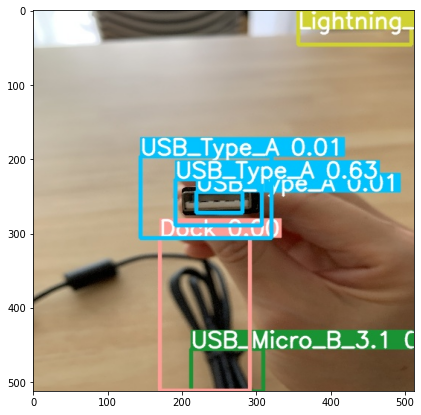

In [56]:
# 推論実行後の画像例
from skimage import exposure
import cv2
import matplotlib.pyplot as plt

def read_img(path):
    data = cv2.imread(path)
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data 

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


paths = glob("/content/yolov5/runs/detect/exp/*")

n = np.random.randint(len(paths))
path = paths[n]
#path = '/content/yolov5/runs/detect/exp2/677aa0a2.jpg'

plot_img(read_img(path))

In [57]:
# テキストでの推論結果
#with open("/content/yolov5/runs/detect/exp/labels/677aa0a2.txt", mode="r") as f:
with open("/content/yolov5/runs/detect/exp/labels/dc2ee521.txt", mode="r") as f:
    data_ = f.read()
data_.split()

['1',
 '0.576172',
 '0.455078',
 '0.222656',
 '0.0703125',
 '0.00108182',
 '7',
 '0.398438',
 '0.961914',
 '0.441406',
 '0.0722656',
 '0.00121646',
 '11',
 '0.606445',
 '0.40332',
 '0.447266',
 '0.208984',
 '0.00125633',
 '4',
 '0.768555',
 '0.960938',
 '0.408203',
 '0.0742188',
 '0.00139632',
 '7',
 '0.0976562',
 '0.958984',
 '0.195312',
 '0.0742188',
 '0.00147635',
 '4',
 '0.588867',
 '0.962891',
 '0.416016',
 '0.0742188',
 '0.00199368',
 '13',
 '0.304688',
 '0.421875',
 '0.582031',
 '0.238281',
 '0.00201175',
 '7',
 '0.21582',
 '0.961914',
 '0.396484',
 '0.0722656',
 '0.0020302',
 '8',
 '0.680664',
 '0.446289',
 '0.345703',
 '0.130859',
 '0.00237977',
 '13',
 '0.277344',
 '0.456055',
 '0.410156',
 '0.146484',
 '0.00308687',
 '1',
 '0.621094',
 '0.415039',
 '0.515625',
 '0.208984',
 '0.00477161',
 '11',
 '0.601562',
 '0.43457',
 '0.425781',
 '0.0957031',
 '0.0466121',
 '1',
 '0.366211',
 '0.452148',
 '0.435547',
 '0.119141',
 '0.0467588',
 '1',
 '0.577148',
 '0.453125',
 '0.412109',


In [58]:
# 実行結果をMYDRIVEへコピー
from distutils.dir_util import copy_tree

OUTPUT = "/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output/"

src = "/content/yolov5/runs/detect/exp/"


dest = f"{OUTPUT}/{yolo_ver}_epoch{epochs}_{current_time}/result_inference/"
if not os.path.exists(dest):
    os.makedirs(dest)

copy_tree(src, dest)

['/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/c82fc7ce.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/f49b714c.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/88faa9b4.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/806b245a.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/2f6543dc.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/f85f52cd.jpg',
 '/content/drive/MyDrive/project/Nishika_cable-detection_summary/YOLO_output//yolov5s_epoch30_2021-11-04-08-19/result_inference/6296b533.jpg',

##submission

In [59]:
# yoloの座標形式からXmin、Ymin、Xmax、Ymax形式に変換
def yolo2voc(img_h, img_w, boxes):
    boxes = boxes.copy().astype(float)

    # 3点ドット... = 組込定数Ellipsis ndarrayの途中の次元を省略
    boxes[..., [0, 2]] = boxes[..., [0, 2]] * img_w
    boxes[..., [1, 3]] = boxes[..., [1, 3]] * img_h

    boxes[..., [0, 1]] = boxes[..., [0, 1]] - boxes[..., [2, 3]]/2
    boxes[..., [2, 3]] = boxes[..., [0, 1]] - boxes[..., [2, 3]]
    
    return boxes

file_ids = []
pred = []

for file_path in tqdm(glob('/content/yolov5/runs/detect/exp/labels/*.txt')):
    file_id = file_path.split('/')[-1].split('.')[0]
    w, h = 512, 512

    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    
    # yoloでの推論結果は1つの　BOXにつき(cls, x, y, w, h, conf)の順で表示されるので(cls, conf, x, y, w, h)へ直しておく。
    # BOXが複数出力される場合は、低い順に表示される
    data = data[:, [0, 5, 1, 2, 3, 4]]

    tmp = np.round(yolo2voc(h, w, data[:, 2:]))
    concat = np.concatenate((data[:, :2], tmp), axis=1)
    boxes = list(np.round(concat.reshape(-1), 12).astype(str))

    for idx in range(len(boxes)):
        boxes[idx] = str(int(float(boxes[idx]))) if idx%6!=1 else boxes[idx]

    file_ids.append(file_id)
    pred.append(' '.join(boxes))
    
pred_df = pd.DataFrame({
    'id': file_ids,
    'PredictionString': pred})

pred_df.head()

  0%|          | 0/2200 [00:00<?, ?it/s]

,id,PredictionString
0,82edc0d5,8 0.001214419957 388 0 264 -27 13 0.0014270800...
1,c0159886,11 0.001025969977 1 2 -51 -65 7 0.001050250023...
2,cd6f3117,11 0.001095009968 212 164 25 31 4 0.0011094299...
3,b1522b7b,7 0.001119890017 205 476 7 441 7 0.00165661994...
4,fb1cfb32,4 0.001013580011 304 362 235 312 7 0.001041620...


In [60]:
class_ls = []
max_conf_ls = []
box_ls = []

for predstring in tqdm(pred_df["PredictionString"].values):
    listfromstr = predstring.split(" ")

    class_ls.append( int(listfromstr[-6]) )
    max_conf_ls.append( float(listfromstr[-5]) )
    box_ls.append( [int(x) for x in listfromstr[-4:] ] )

pred_df["classID"] = class_ls
pred_df["cofidence"] = max_conf_ls
pred_df["box"] = box_ls

pred_df["class"] = pred_df["classID"].apply(lambda x: dict_label[x])
pred_df["filename"] = pred_df["id"].apply(lambda x: x+".jpg")

pred_df.head()

  0%|          | 0/2200 [00:00<?, ?it/s]

,id,PredictionString,classID,cofidence,box,class,filename
0,82edc0d5,8 0.001214419957 388 0 264 -27 13 0.0014270800...,13,0.567031,"[226, 217, 148, 181]",USB_Type_C,82edc0d5.jpg
1,c0159886,11 0.001025969977 1 2 -51 -65 7 0.001050250023...,2,0.467450,"[267, 320, 172, 285]",HDMI,c0159886.jpg
2,cd6f3117,11 0.001095009968 212 164 25 31 4 0.0011094299...,11,0.570824,"[180, 198, 38, 143]",USB_Type_A,cd6f3117.jpg
3,b1522b7b,7 0.001119890017 205 476 7 441 7 0.00165661994...,12,0.540354,"[200, 191, 65, 105]",USB_Type_B,b1522b7b.jpg
4,fb1cfb32,4 0.001013580011 304 362 235 312 7 0.001041620...,3,0.537766,"[199, 211, 121, 167]",Lightning,fb1cfb32.jpg


In [61]:
submission = pred_df[["filename","class"]]
submission.to_csv("/content/drive/MyDrive/project/Nishika_cable-detection_summary/submission.csv", index=False)

In [ ]:
submission

,filename,class
0,ccdb07b0.jpg,USB_Micro_B
1,af8f3ca0.jpg,Dock
2,81cb2c83.jpg,USB_Type_B
3,025f8e0f.jpg,RJ_45
4,f283264f.jpg,RJ_45
...,...,...
2195,b382d571.jpg,USB_Micro_B_3.1
2196,007bb9f0.jpg,USB_Micro_B
2197,b0f59ce1.jpg,USB_Type_C
2198,58b56ca5.jpg,USB_Micro_B_3.1
